## Motivation  
Quite often, ensemble models work considerably better than linear/logistic regession models.

However, while linear models provide a coefficient for each variable ,that can be easily translated to it's effect on the explained variable direction (i.e. - negative/positive coefficient suggests negative/positive correlation with the explained variable,respectively), ensemble models doesn't provide this type of information.

That's because trees can result different splits for the same variable - some can have positive (value larger than split point leads to higher outcome value) and others negative effect in different estimators (trees).

Thus, proposed here a new method. The method is applied on Random Forest model and provides the average effect on the outcome - the more negative/positive the resulted value, the more the negative/positive effect on the explained variable (the Outcome).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = pd.read_csv("diabetes.csv")

#### Which data types are the columns?

### Impute Zero values here: 

In [3]:
f_impute_zeros = f.copy()

In [4]:
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_impute_zeros.loc[f_impute_zeros[col]==0,col] = f_impute_zeros.loc[f[col]>0,col].mean()
    #f = f[f[col]>0]

In [5]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [6]:
import xgboost as xgb

In [7]:
model=ensemble.RandomForestClassifier(min_samples_leaf=5)
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.87890625
0.9529402985074626


/home/oz/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Following decision path for each sample
The script below follows Random Forest's [Decision pathway](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html).

* Sample 150 samples which were modeled
* Follow the path for each sample : 
    * Take the whole dataset and filter it according to each split.
    * At each split, calculate the average of the Outcome/predicted variable.
    * For each split, calculate the **difference** : Average outcome before split minus avg outcome after split.
    * The difference represents the **direction** : whether the split increase or decreases the outcome values.
* Repeat the process to all trees in model.
* Finally, generates a table which calculates the **average difference at all splits for a given variable**. 
* Interpretation : **"<=" sign with negative average value means that in the decision paths, following lower values of the variable will result lower outcome values, and otherwise if sign is ">".**



![title](Untitled.png)

In [8]:

X_test = f_impute_zeros.drop(outcome,1).sample(150) # Select 150 samples from the data
orig_table = f_impute_zeros.copy()
outcome = 'Outcome'



feature_names = pd.Series(f_impute_zeros.drop(outcome,1).columns)
feature_names[-2] = None


dict_signs = {}
for col in X_test.columns: 
    dict_signs[col] = {}
    dict_signs[col]["<="] = []
    dict_signs[col][">"] = []
    
    
for sample_id in range(len(X_test)):  # For each of the selected samples

    for i,estimator in enumerate(model.estimators_): # For each tree in Forest
        xt = orig_table.drop(outcome,1) 

        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold
        node_indicator = estimator.decision_path(X_test)

        # Similarly, we can also have the leaves ids reached by each sample.

        leave_id = estimator.apply(X_test)

        # Now, it's possible to get the tests that were used to predict a sample or
        # a group of samples. First, let's make it for the sample.

        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]

        for node_id in node_index:
            if leave_id[sample_id] == node_id:
                continue

            if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"
        
            prev_mean = orig_table.loc[xt.index,outcome].mean()
            exec('xt = xt[xt["'+feature_names[feature[node_id]]+'"]'+threshold_sign+str(threshold[node_id])+']')
            new_mean = orig_table.loc[xt.index,outcome].mean()
            
            dict_signs[feature_names[feature[node_id]]][threshold_sign] += [new_mean - prev_mean]
       

In [9]:
directions = pd.DataFrame(dict_signs).T.apply(lambda x: x.apply(lambda y: np.mean(y))).dropna()

In [10]:
directions.style.applymap(lambda x: 'color: red' if x<0 else  'color: green' )

,<=,>
Pregnancies,-0.0408322,0.0766269
Glucose,-0.118297,0.176732
BloodPressure,-0.0056382,0.00483305
SkinThickness,-0.0380135,0.0314342
Insulin,-0.00524777,0.0262239
BMI,-0.0789666,0.0743955
DiabetesPedigreeFunction,-0.0477461,0.0449223
Age,-0.0530017,0.0668488


Finally, substract the '<=' direction  from '>' direction. For example, Glucose variable has strong positive/negative effect on the outcome when following a path towards higher/lower Glucose values. Hence, **Their subtraction will provide stronger estimate for the effect of each variable on the outcome's direction**

In [11]:
directions.T.diff().iloc[1]

Pregnancies                 0.117459
Glucose                     0.295030
BloodPressure               0.010471
SkinThickness               0.069448
Insulin                     0.031472
BMI                         0.153362
DiabetesPedigreeFunction    0.092668
Age                         0.119851
Name: >, dtype: float64

### Now, let's compare with logistic regression, which provides explicit coefficients:

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
# We'll standadize variables in order to get meaningful coefficients: 
model = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

In [14]:
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.7760416666666666
0.8463134328358208


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/oz/.local/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/oz/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oz/.local/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/oz/.local/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all c

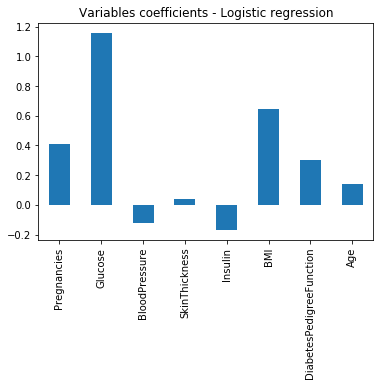

In [15]:
pd.Series(index=f_impute_zeros.drop(outcome,1).columns, data=model.steps[1][1].coef_[0]).plot(kind = 'bar')
plt.title('Variables coefficients - Logistic regression')
plt.show()

### Now, let's compare the "direction score" of random forest Vs logistic regression coefficients: 

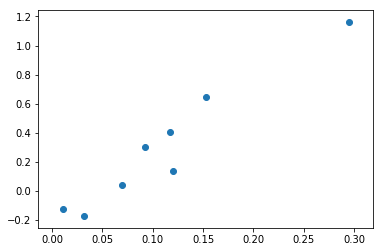

In [16]:
plt.scatter(directions.T.diff().iloc[1], model.steps[1][1].coef_[0])

In [17]:
pd.Series(index=directions.T.diff().iloc[1], data=model.steps[1][1].coef_[0]).reset_index().corr()

,>,0
>,1.000000,0.965647
0,0.965647,1.000000


#### Fiarly correlated !

## Conclusions:
* We aimed to find a method that can produce equivalent to variables coefficients in logistic/linear regression
* For each variable, the suggested method maps the effect of each split on the outcome (higher/lower enrichment of the outcome)
* The method was applied on diabetes dataset and compared with logistic regression coefficients.
* Interestingly, the method was very correlated with the coefficients achieved by loistic regression. This implies for fairly linear correlations between the variables and the outcome. However, in cases of non-linear relations, it is expected that randomforests will produce very different results and will help to provide additional insights that could not be achieved by the linear models.